In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from datetime import datetime
from datetime import date
import pickle
import os
from math import exp

In [2]:
mem_bin_cutoffs = [50, 100, 200, 500, 1000, 2000, 10000, 20000, 50000, 100000]
mem_categories = {i:mem_bin_cutoffs[i] for i in range(len(mem_bin_cutoffs))}

In [3]:
print(mem_categories)

{0: 50, 1: 100, 2: 200, 3: 500, 4: 1000, 5: 2000, 6: 10000, 7: 20000, 8: 50000, 9: 100000}


In [4]:
save_folder_path = '/glade/work/jdubeau/model-saves/class_forest2021-06-23-13:58/'

In [5]:
model = pickle.load(open(save_folder_path+'model.pkl','rb'))
model_df = pickle.load(open(save_folder_path+'model_df.pkl', 'rb'))
X_train = pickle.load(open(save_folder_path+'X_train.pkl', 'rb'))
y_train_full = pickle.load(open(save_folder_path+'y_train_full.pkl', 'rb'))
X_val = pickle.load(open(save_folder_path+'X_val.pkl', 'rb'))
y_val_full = pickle.load(open(save_folder_path+'y_val_full.pkl', 'rb'))
X_test = pickle.load(open(save_folder_path+'X_test.pkl', 'rb'))
y_test_full = pickle.load(open(save_folder_path+'y_test_full.pkl', 'rb'))

In [6]:
y_train = y_train_full['mem_category']
y_val = y_val_full['mem_category']
y_test = y_test_full['mem_category']

In [7]:
y_train_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25107 entries, 6220696 to 6203484
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   req_mem       25107 non-null  float64
 1   used_mem      25107 non-null  float64
 2   mem_category  25107 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 784.6 KB


In [8]:
def plot_cm():
    plot_confusion_matrix(model, X_val, 
                          y_val, normalize='true', 
                          values_format='.2f')

In [9]:
def print_cr():
    print(classification_report(y_val, model.predict(X_val)))

In [10]:
def auc():
    print(roc_auc_score(y_val, 
                        model.predict_proba(X_val),
                        average='weighted',
                        multi_class='ovr'))

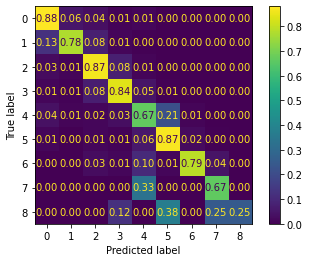

In [11]:
plot_cm()

In [12]:
print_cr()

              precision    recall  f1-score   support

           0       0.92      0.88      0.90      5653
           1       0.86      0.78      0.82      2831
           2       0.78      0.87      0.82      2142
           3       0.71      0.84      0.77       792
           4       0.57      0.67      0.62       410
           5       0.83      0.87      0.85       648
           6       0.62      0.79      0.70        67
           7       0.14      0.67      0.24         3
           8       1.00      0.25      0.40         8

    accuracy                           0.85     12554
   macro avg       0.72      0.74      0.68     12554
weighted avg       0.85      0.85      0.85     12554



In [13]:
auc()

0.9718435717819608


In [45]:
def predict(entries, scale_factor=1.0):
    predictions = []
    for cat in model.predict(entries):
        mem_val = mem_categories[cat]
        mem_val *= 1 + 2*exp((-1*mem_val) / 10000.0)
        mem_val = round(mem_val)
        predictions.append(mem_val)
    return predictions

In [46]:
df = y_val_full.copy()
df['mem_delta'] = df.apply(lambda row: 
                           row['req_mem'] - row['used_mem'],
                           axis=1)


In [47]:
df['pred_cat'] = model.predict(X_val)
df['pred_mem'] = predict(X_val)
df['pred_delta'] = df.apply(lambda row: row['pred_mem'] - row['used_mem'],
                            axis=1)

In [48]:
df.sample(10)

,req_mem,used_mem,mem_category,mem_delta,pred_cat,pred_mem,pred_delta
6449441,1024.0,34.597656,0,989.402344,0,150,115.402344
6406395,4096.0,156.234375,2,3939.765625,2,592,435.765625
6476419,2048.0,156.593750,2,1891.406250,2,592,435.406250
6224222,20480.0,631.511719,4,19848.488281,4,2810,2178.488281
6701384,2048.0,161.632812,2,1886.367188,2,592,430.367188
6524139,2048.0,157.554688,2,1890.445312,2,592,434.445312
6506880,1024.0,102.515625,2,921.484375,2,592,489.484375
6202758,2048.0,42.476562,0,2005.523438,0,150,107.523438
6321888,1024.0,77.828125,1,946.171875,4,2810,2732.171875
6600560,2048.0,67.222656,1,1980.777344,1,298,230.777344


In [53]:
def total_loss():
    print("Total unused memory in GB (original): "
          + f"{round(df['mem_delta'].sum()/1024)}")
    print("Total unused memory in GB (predicted): "
          + f"{round(df['pred_delta'].sum()/1024)}")
    print("Number of jobs using more than predicted: "
          + f"{df[df.pred_delta < 0].shape[0]}")
    print("Sample of jobs using more than predicted: ")
    print(df[df.pred_delta < 0].sample(10))

In [54]:
total_loss()

Total unused memory in GB (original): 66042
Total unused memory in GB (predicted): 8474
Number of jobs using more than predicted: 91
Sample of jobs using more than predicted: 
         req_mem     used_mem  mem_category     mem_delta  pred_cat  pred_mem  \
6525638  30720.0  3668.066406             6  27051.933594         4      2810   
6177199   1024.0   330.847656             3    693.152344         0       150   
6368730   2048.0   187.753906             2   1860.246094         0       150   
6248713   1024.0   711.457031             4    312.542969         2       592   
6220178    512.0   181.378906             2    330.621094         0       150   
6395213   4096.0   616.785156             4   3479.214844         2       592   
6529489  20480.0   325.253906             3  20154.746094         1       298   
6387277  20480.0  4802.363281             6  15677.636719         4      2810   
6406380   2048.0   355.339844             3   1692.660156         0       150   
6362419   2048